In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
import recordreader

In [3]:
K = np.load("../../tools/camcal/camera_matrix.npy")
dist = np.load("../../tools/camcal/dist_coeffs.npy")
K[:2] /= 4.05
fx, fy = np.diag(K)[:2]
cx, cy = K[:2, 2]
K

array([[187.16562302,   0.        , 317.61997568],
       [  0.        , 187.77060777, 220.9114768 ],
       [  0.        ,   0.        ,   1.        ]])

In [39]:
K2 = np.float32([
    [200, 0, 320],
    [0, 200, 240],
    [0, 0, 1]
])

t0 = 0
f = open("../../logs/cl20190420/cycloid-20190420-172107.rec", "rb")
ts0 = None
delay = 0
ceilmap = np.ones((100, 100))*255*2
ceilmapN = np.ones((100, 100))*2
ceili, ceilj = 50, 50

def update_ceilmap(tmpl, i, j):
    sy, sx = tmpl.shape
    bestdi, bestdj, bestmatch = None, None, None
    for di in [0, -1, 1]:
        for dj in [0, -1, 1]:
            c = ceilmap[j+dj:j+dj+sy, i+di:i+di+sx]
            m = np.sum(np.abs(c - tmpl*ceilmapN[j+dj:j+dj+sy, i+di:i+di+sx])**2)
            #print(di, dj, m)
            if bestmatch is None or m < bestmatch:
                bestdi, bestdj, bestmatch = di, dj, m
    i += bestdi
    j += bestdj
    ceilmap[j:j+sy, i:i+sx] += tmpl
    ceilmapN[j:j+sy, i:i+sx] += 1
    return i, j

lastu, lastv = None, None
while True:
    ok, frame = recordreader.read_frame(f)
    if not ok:
        break
    gray = frame['yuv420'][:480]
    bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
    cv2.imshow("bgr", bgr)
    if ts0 is None:
        ts0 = frame['tstamp'] - 1.0/30
    ts = frame['tstamp']
    dt = ts - ts0
    ts0 = ts
    gz = frame['carstate'][3][2]
    und = cv2.fisheye.undistortImage(gray, K, dist, None, K2)
    
    und2 = np.float32(und) - np.mean(und)
    stride = 1
    res = 1
    dx = und2[stride::res, stride::res] - und2[stride::res, :-stride:res]
    dy = und2[stride::res, stride::res] - und2[:-stride:res, stride::res]
    
    def Nstep(theta, dx, dy):
        x0 = np.cos(theta)
        x1 = dx*x0
        x2 = np.sin(theta)
        x3 = dy*x2
        x4 = x1 + x3
        x5 = x4**2
        x6 = dy*x0
        x7 = dx*x2
        x8 = x6 - x7
        x9 = x8**2
        o = np.fmin(x5, x9)
        g = x4*(2*x6 - 2*x7)*(x9 > x5) + x8*(-2*x1 - 2*x3)*(x5 >= x9)
        return o, g

    t0 -= gz*dt
    
    #t0 = 0.1
    #o, g = Nstep(t0, dx, dy)
    #o1, g1 = Nstep(t0+1e-2, dx, dy)
    #print(o, g, '-', 1e2*(o1-o))
    
    for i in range(2):
        o, g = Nstep(t0, dx, dy)
        #print(t0*180/np.pi, o, g)
        w = 1.0 / np.maximum(np.sqrt(o), 1)
        o = np.sum(o)
        g = np.sum(g*w)
        t0 -= g/(6*o)
    
    if False:
        os = []
        gs = []
        ggs = []
        for t in np.linspace(0, np.pi, 100):
            o, g = Nstep(t, dx, dy)
            os.append(o)
            gs.append(g)
            if t > 0:
                ggs.append(100*(os[-1] - os[-2])/np.pi)
        plt.plot(os)
        plt.plot(gs)
        plt.plot(ggs)
        break
    
    cv2.line(und, (320, 240), (320+int(100*np.cos(t0)), 240+int(100*np.sin(t0))), 255, 1)
    cv2.line(und, (320, 240), (320-int(100*np.sin(t0)), 240+int(100*np.cos(t0))), 255, 1)
    cv2.putText(und, "%0.1f, %0.1f" % (o, g), (20, 20), cv2.FONT_HERSHEY_PLAIN, 1, 255)

    C, S = np.cos(t0), np.sin(t0)
    g = 30  # grid spacing
    k3z = 4*g
    K3 = np.float32([
        [k3z*C, k3z*S, 150],
        [-k3z*S, k3z*C, 150],
        [0, 0, 1],
    ])
    ualign = cv2.fisheye.undistortImage(gray, K, dist, None, K3, (300, 300))
    
    def offset(dx, g):
        kernel = np.zeros(300-g)
        kernel[np.arange(0, 300-g, g)] = 1
        kernel[np.arange(1, 300-g, g)] = -1
        #kernel -= np.mean(kernel)
        c = np.convolve(np.sum(dx, axis=0), kernel, mode='valid')
        u = np.argmax(c)
        return u
    
    uf = ualign.astype(np.int32)
    dx = uf[1:, 1:] - uf[1:, :-1]
    dy = uf[1:, 1:] - uf[:-1, 1:]
    u = offset(dx[:, :], g)
    v = offset(dy[:, :].T, g)
    #u = (u+20)%g
    #v = (v+20)%g
    osize = (300-g)//g
    for i in range(u, 300, g):
        cv2.line(ualign, (i, 0), (i, 300), 180, 5)
    for i in range(v, 300, g):
        cv2.line(ualign, (0, i), (300, i), 180, 5)

    #tmpl = cv2.resize(ualign[v:v+g*osize, u:u+g*osize], (osize, osize), interpolation=cv2.INTER_AREA)
    #cv2.imshow("template", cv2.resize(tmpl, (osize*40, osize*40), interpolation=cv2.INTER_NEAREST))
    
    #if lastu is not None:
    #    du = (u - lastu) % g
    #    dv = (v - lastv) % g
    #    if du < g/2 and u < lastu:  # wrapped right
    #        ceili -= 1
    #    if du > g/2 and u > lastu:  # wrapped left
    #        ceili += 1
    #    if dv < g/2 and v < lastv:  # wrapped down
    #        ceilj -= 1
    #    if dv > g/2 and v > lastv:  # wrapped up
    #        ceilj += 1
            
    #lastu, lastv = u, v
    #ceili, ceilj = update_ceilmap(tmpl, ceili, ceilj)
    
    #m = cv2.resize((ceilmap/ceilmapN).astype(np.uint8), (900, 900), interpolation=cv2.INTER_NEAREST)
    #cv2.circle(m, (ceili*9 + 5, ceilj*9 + 5), 6, 0, 1)
    #cv2.imshow("ceilingmap", m)

    cv2.line(ualign, (150-5, 150-5), (150+5, 150+5), 255, 1)
    cv2.line(ualign, (150-5, 150+5), (150+5, 150-5), 255, 1)

    cv2.imshow("aligned", ualign)
    
    cv2.imshow("ceiling", und)
    k = cv2.waitKey(delay)
    if k == ord('g'):
        delay = 1
    if k == ord(' '):
        delay = 0
    if k == ord('q'):
        break

f.close()
cv2.destroyAllWindows()
cv2.waitKey(1)

/Users/asloane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


-1

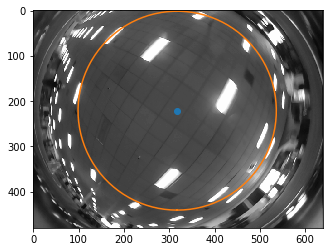

In [40]:
y = frame['yuv420'][:480]
plt.imshow(y, cmap='gray')
plt.plot(cx, cy, 'o')
t = np.linspace(0, 2*np.pi, 100)
ang = 67*np.pi/180
plt.plot(cx + fx*ang*np.sin(t), cy + fy*ang*np.cos(t))

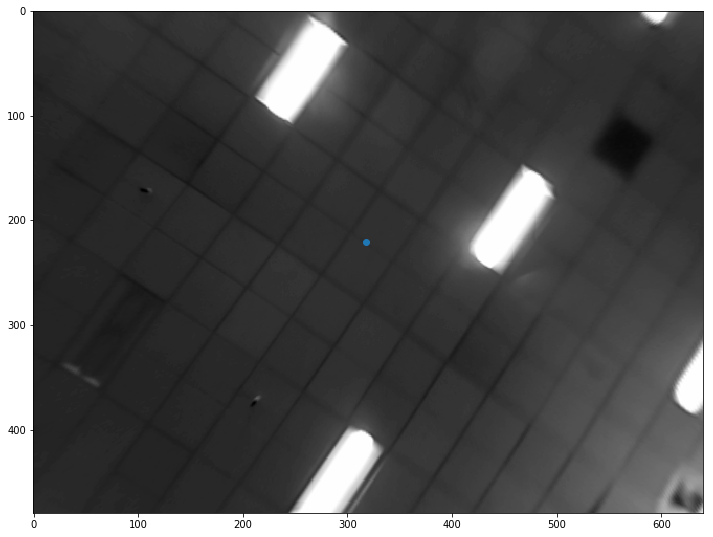

In [41]:
und = cv2.fisheye.undistortImage(frame['yuv420'][:480], K, dist, None, K2)
plt.figure(figsize=(12,10))
plt.plot(cx, cy, 'o')
plt.imshow(und, cmap='gray')

/Users/asloane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


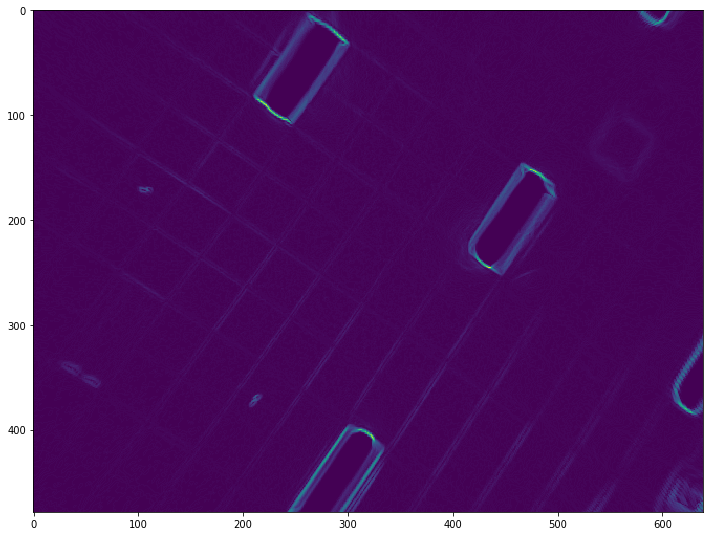

In [42]:
und2 = np.float32(und) - np.mean(und)
dx = und2[1:, 1:] - und2[1:, :-1]
dy = und2[1:, 1:] - und2[:-1, 1:]

dxx = dx[1:, 1:] - dx[1:, :-1]
dxy = dx[1:, 1:] - dx[:-1, 1:]
dyx = dy[1:, 1:] - dy[1:, :-1]
dyy = dy[1:, 1:] - dy[:-1, 1:]
plt.figure(figsize=(12,10))
plt.imshow(np.sqrt(dx**2 + dy**2))

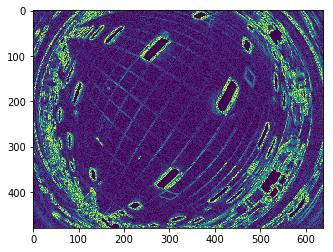

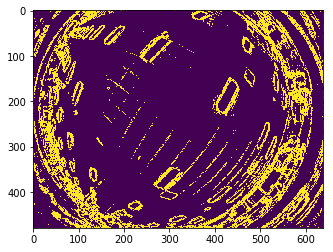

In [44]:
Ix = y[1:, 1:] - y[1:, :-1]
Iy = y[1:, 1:] - y[:-1, 1:]

plt.imshow(np.sqrt(Ix**2 + Iy**2).astype(np.float32))
plt.show()
plt.imshow(Ix**2 + Iy**2 > 20)

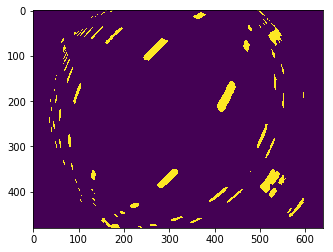

In [47]:
plt.imshow(y > 240)

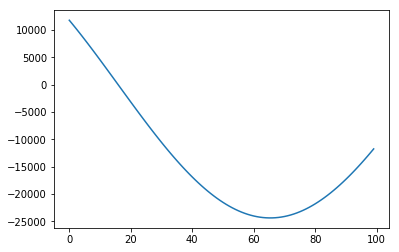

In [837]:
t = np.linspace(0, np.pi, 100)
S = np.sin(t)
C = np.cos(t)
mag = np.sum(np.outer(dx.reshape(-1), C) + np.outer(dy.reshape(-1), S), axis=0)
plt.plot(mag)
ang = np.pi * np.argmax(np.abs(mag)) / 100.0

In [838]:
ang = np.arctan2(np.sum(dy), np.sum(dx))
ang

-1.0673356

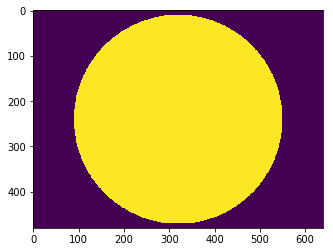

In [839]:
ji = np.mgrid[:und2.shape[0], :und2.shape[1]]
filt = (ji[0] - 240)**2 + (ji[1] - 320)**2 < 230**2
plt.imshow(filt)

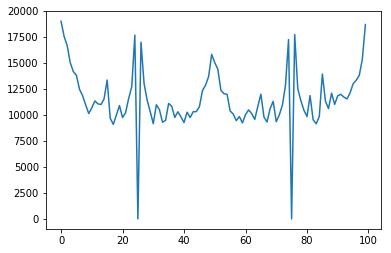

In [840]:
# remap image onto line at angle theta
def project2line(im, theta):
    S, C = np.sin(theta), np.cos(theta)
    ji = np.mgrid[:im.shape[0], :im.shape[1]]
    i = (ji[0]*S + ji[1]*C)
    i = np.round(i).astype(np.int) % 640
    z = np.zeros(640)
    filt = (ji[0] - 240)**2 + (ji[1] - 320)**2 < 230**2
    np.add.at(z, i[filt], im[filt])
    return z

ts = np.zeros(100)
for i in range(100):
    proj = project2line(np.sqrt(dx**2 + dy**2), i*np.pi/100.)
    rot = np.concatenate([proj[1:], proj[:1]])
    ts[i] = np.sum(np.abs(proj - rot))

ts[25] = 0
ts[75] = 0
plt.plot(ts)

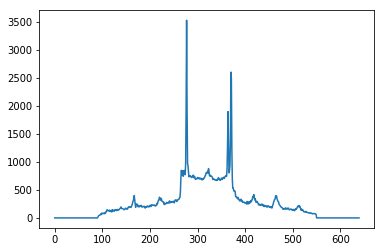

In [841]:
ang = np.pi*np.argmax(ts) / 100.0
plt.plot(project2line(np.sqrt(dx**2 + dy**2), ang))

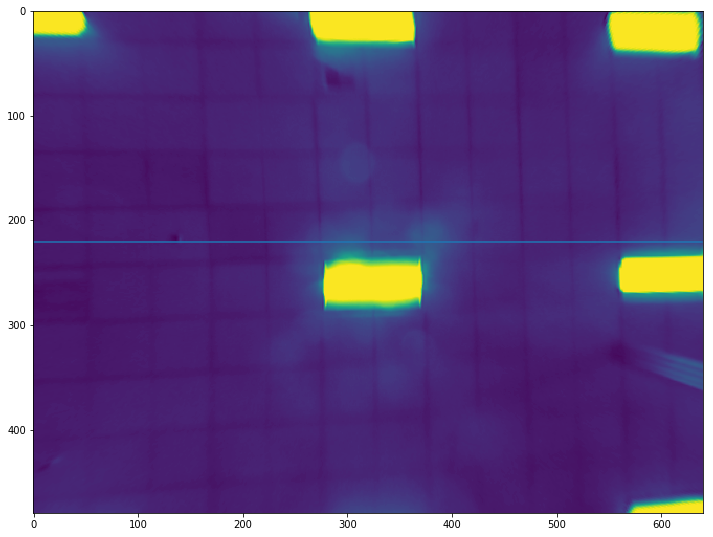

In [842]:
plt.figure(figsize=(12,10))
plt.imshow(und2)
x = np.arange(und2.shape[1]) - cx
plt.plot(np.clip(x * np.tan(ang) + cy, 0, 479))

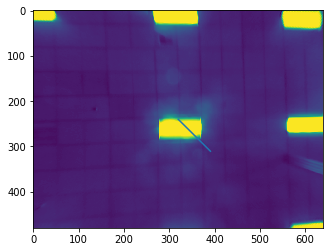

In [843]:
q1 = (dx >= 0) & (dy >= 0)
q2 = (dx < 0) & (dy >= 0)
q3 = (dx < 0) & (dy < 0)
q4 = (dx >=0) & (dy < 0)

xx = np.sum(dx[q1]) + np.sum(dy[q2]) - np.sum(dx[q3]) - np.sum(dy[q4])
yy = np.sum(dy[q1]) - np.sum(dx[q2]) - np.sum(dy[q3]) + np.sum(dx[q4])
xy = np.float32([xx, yy])
xy /= np.linalg.norm(xy)
xx, yy, xy
plt.imshow(und2)
plt.plot([320, 100*xy[0]+320], [240, 100*xy[1]+240])

In [844]:
t = np.linspace(0, np.pi/2, 101)[:100]
C = np.cos(t)
S = np.sin(t)

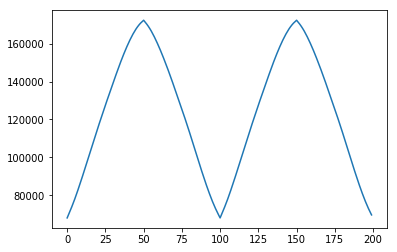

In [845]:
#und2 = cv2.GaussianBlur(und, (5, 5), 2)
und2 = np.float32(und) - np.mean(und)
#d3 = np.sqrt(dx**2 + dy**2)
dx = und2[1:, 1:] - und2[1:, :-1]
dy = und2[1:, 1:] - und2[:-1, 1:]
rsum = np.sum(np.fmin(np.abs(dx[:, :, None]*C + dy[:, :, None]*S),
                      np.abs(-dx[:, :, None]*S + dy[:, :, None]*C)), axis=(0,1))
plt.plot(np.concatenate([rsum, rsum]))

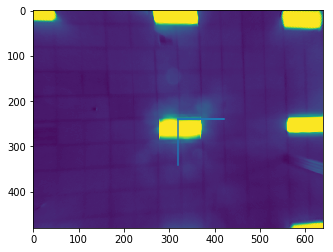

In [846]:
plt.imshow(und2)
#rsum = np.sum(np.abs(dx[:, :, None]*C + dy[:, :, None]*S), axis=(0,1))
i = np.argmin(rsum)
plt.plot([320, 100*C[i]+320, 320, -100*S[i]+320], [240, 100*S[i]+240, 240, 100*C[i]+240])

In [847]:
def aligniter(theta):
    C = np.cos(theta)
    S = np.sin(theta)
    rsum = np.sum(np.abs(dx*C + dy*S))
    grad = np.sum((-dx*S + dy*C) * np.sign(dx*C + dy*S))
    return rsum, grad

t0 = 0
for i in range(10):
    v, g = aligniter(t0)
    print(v, g)
    t0 -= 1e-6*g

163094.0 37547.0
164893.92 -49861.316
164615.42 122540.21
169199.45 -65531.254
165258.4 -52180.414
164021.83 123333.62
169580.36 -67754.55
165437.62 -53132.07
163719.56 123734.63
169773.23 -67682.12


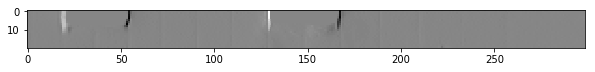

In [848]:
uf = ualign.astype(np.int32)
dx = uf[1:, 1:] - uf[1:, :-1]
dy = uf[1:, 1:] - uf[:-1, 1:]
plt.figure(figsize=(10,10))
plt.imshow(dx[140:160, :], cmap='gray')
#g = np.mgrid[:8, :8]
#plt.plot(150, 150, '+')
#plt.scatter(g[0]*39+10, g[1]*39+10)
#plt.plot(150, 150, 'x')


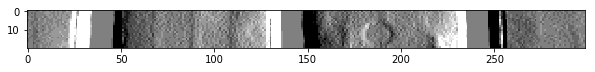

In [857]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(dy[:, 140:160].T, -5, 5), cmap='gray')

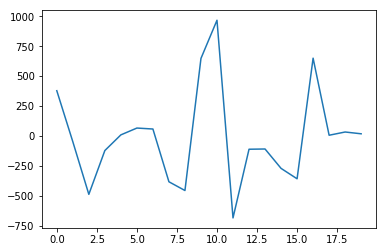

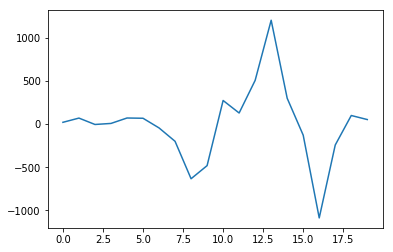

In [855]:
# this is simple, and works, provided you know the periodicity

g = 20
kernel = np.zeros(300-g)
#kernel[0] = 1
#kernel[1] = -1
kernel[np.arange(0, 300-g, g)] = 1
kernel[np.arange(1, 300-g, g)] = -1
kernel -= np.mean(kernel)
#kernel = np.cos(np.arange(80)*2*np.pi/20.)**2
#kernel -= np.mean(kernel)
#plt.plot(kernel)
plt.plot(np.convolve(np.sum(dx[140:160, :], axis=0), kernel, mode='valid'))
#plt.plot(np.sum(-dx[140:160, 100:200] + dx[140:160, 101:201], axis=0))

# can be implemented just by adding dx to bucket x%g and -dx to bucket (x+1)%g for all dx

plt.show()
plt.plot(np.convolve(np.sum(dy[:, 140:160].T, axis=0), kernel, mode='valid'))


In [851]:
# this doesn't work.

def xalign(Ix, u, f):
    w = ((Ix.astype(np.float32)**2).reshape(-1))
    x = np.mgrid[:Ix.shape[0], :Ix.shape[1]][1].reshape(-1)
    # compute weighted residual
    x0 = x - u
    x1 = f*x0
    x2 = np.cos(x1)
    r = np.sin(x1)
    J = np.vstack([f*x2])
    print(J.shape, r.shape)
    JTJ = np.dot(np.dot(J, np.diag(w)), J.T)
    JTr = np.dot(np.dot(J, np.diag(w)), r)
    print(JTJ)
    print(JTr)
    soln = np.linalg.lstsq(JTJ, JTr, rcond=None)[0]
    print(u, f, soln)
    return soln
    
    # compute J^TwJ^(-1) J^Twr

u1 = xalign(dx[140:160, 110:210], 0, 2*np.pi/20.)
u2 = xalign(dx[140:160, 110:210], u1, 2*np.pi/20.)


(1, 2000) (2000,)
[[11423.67685086]]
[-21126.89118689]
0 0.3141592653589793 [-1.84939503]
(1, 2000) (2000,)
[[16611.41580886]]
[-4022.29461633]
[-1.84939503] 0.3141592653589793 [-0.24214038]


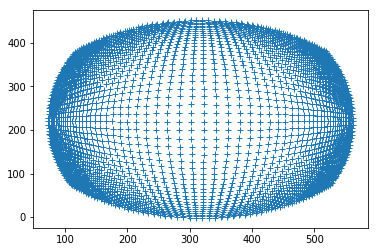

In [1022]:
uv = np.mgrid[:480, :640][[1, 0]].transpose(1, 2, 0).astype(np.float32)
xyp = (uv - np.array([cx, cy])) * np.array([2/fx, 2/fy])
#r = np.sqrt(xyp[:, :, 0]**2 + xyp[:, :, 1]**2)
pts = cv2.fisheye.distortPoints(xyp, K, dist)
plt.plot(pts[::10, ::10, 0].reshape(-1), pts[::10, ::10, 1].reshape(-1), '+')

5.7496214

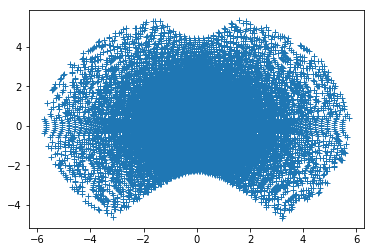

In [1116]:
uv = np.mgrid[:480, :640][[1, 0]].transpose(1, 2, 0).astype(np.float32)
mask = ((uv[:, :, 1] - cy)**2 + (uv[:, :, 0] - cx)**2) < (np.pi/2.2 * fx)**2
pts = cv2.fisheye.undistortPoints(uv[None, mask], K, dist)

#mask = (np.abs(pts[:, :, 0]) < 5) & (np.abs(pts[:, :, 1]) < 5)
#pts[mask].shape

plt.plot(pts[::10, ::10, 0].reshape(-1), pts[::10, ::10, 1].reshape(-1), '+')
np.max(np.linalg.norm(pts[0], axis=1))

(57.63893020872518, 243.50511029247724, 57.210894570622955, 242.9217872192173)

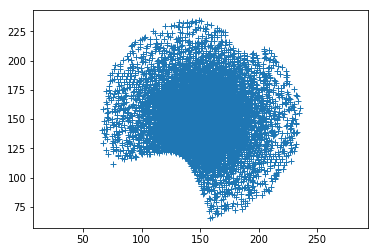

In [1082]:
theta = 0.5
S, C = np.sin(theta), np.cos(theta)
R = np.array([[C, S], [-S, C]])
p = np.dot(pts[0], R.T)*15 + np.array([150, 150])
plt.plot(p[::20, 0].reshape(-1), p[::20, 1].reshape(-1), '+')
plt.axis('equal')


214307.0

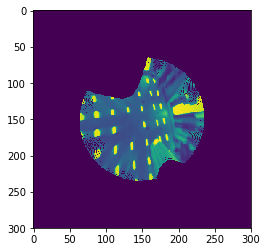

In [1109]:
pi = p.astype(np.int)
pt = p - pi
blah = np.zeros((300, 300))
blah2 = np.zeros((300, 300))
np.add.at(blah, (pi[:, 1], pi[:, 0]), 1)
np.add.at(blah2, (pi[:, 1], pi[:, 0]), gray[mask])
plt.imshow(blah2/(blah+0.1))
np.sum(blah)

214307.0

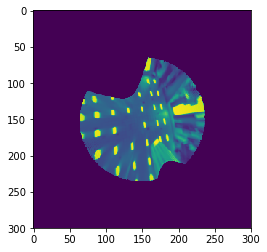

In [1110]:
pi = p.astype(np.int)
pt = p - pi
t00 = (1-pt[:, 1])*(1-pt[:, 0])
t01 = (1-pt[:, 1])*(pt[:, 0])
t10 = (pt[:, 1])*(1-pt[:, 0])
t11 = (pt[:, 1])*(pt[:, 0])
blah = np.zeros((300, 300))
blah2 = np.zeros((300, 300))
np.add.at(blah, (pi[:, 1], pi[:, 0]), t00)
np.add.at(blah, (pi[:, 1], pi[:, 0]+1), t01)
np.add.at(blah, (pi[:, 1]+1, pi[:, 0]), t10)
np.add.at(blah, (pi[:, 1]+1, pi[:, 0]+1), t11)

np.add.at(blah2, (pi[:, 1], pi[:, 0]), t00*gray[mask])
np.add.at(blah2, (pi[:, 1], pi[:, 0]+1), t01*gray[mask])
np.add.at(blah2, (pi[:, 1]+1, pi[:, 0]), t10*gray[mask])
np.add.at(blah2, (pi[:, 1]+1, pi[:, 0]+1), t11*gray[mask])


plt.imshow(blah2/(blah+0.1))  

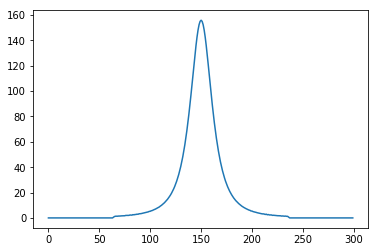

In [1119]:
plt.plot(blah[150])

In [1212]:
poses = np.load("../../tools/bundleadj/poses.npy")
ceilN = np.load("../../tools/bundleadj/ceilmapN.npy")
ceilY = np.load("../../tools/bundleadj/ceilmapY.npy")


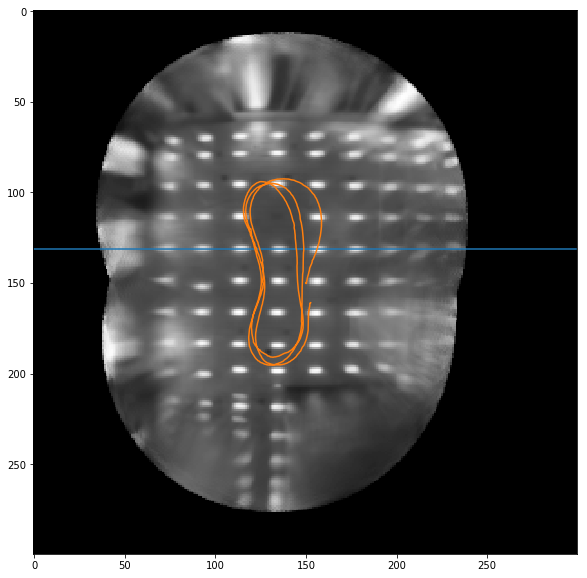

In [1213]:
plt.figure(figsize=(10,10))
plt.imshow(ceilY/ceilN, cmap='gray')
plt.plot(131.5-np.arange(300)*0.0)
plt.plot(poses[:, 0], poses[:, 1])


In [1214]:
np.arctan(0.09)

0.08975817418995052

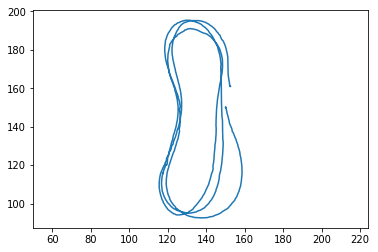

In [1215]:
plt.axis('equal')
plt.plot(poses[:, 0], poses[:, 1])

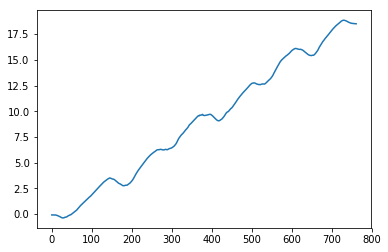

In [1216]:
plt.plot(poses[:, 2])

In [1217]:
14*4./3

18.666666666666668

In [1218]:
180*640.0/fx/np.pi

195.9189849999362

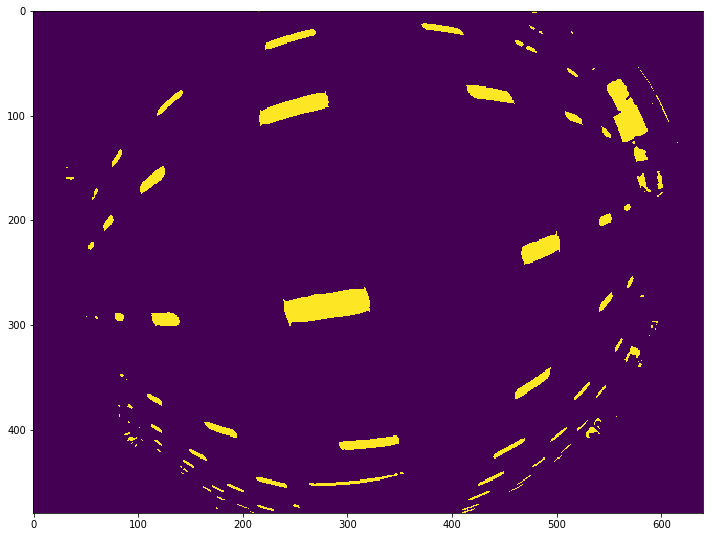

In [1219]:
plt.figure(figsize=(12,10))
plt.imshow(gray >= 240)

In [1220]:
np.max(und) - np.mean(und)

169.32514973958334

In [1228]:
#plt.plot(np.linalg.norm(poses[6:,:2] - poses[5:-1,:2], axis=1))
#plt.plot(0.06*poses[6:, 4])
np.mean(np.linalg.norm(poses[6:-8,:2] - poses[5:-9,:2], axis=1) / poses[6:-8, 4])


0.06642795341396757

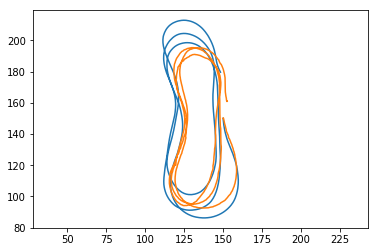

In [1236]:
th = poses[0, 2] - np.cumsum(poses[:, 3] * poses[:, 5])
S, C = np.sin(th), np.cos(th)
xo = np.cumsum(-S*poses[:, 4]*0.066) + 150
yo = np.cumsum(-C*poses[:, 4]*0.066) + 150
plt.axis('equal')
plt.plot(xo, yo)
plt.plot(poses[:, 0], poses[:, 1])

In [1237]:
cv2.circle?